# <font color = "blue"> Gesture Recognition

**Premise :** Gesture recognition can be seen as a way for computers to begin to understand human body language, thus building a better bridge between machines and humans than older text user interfaces or even GUIs (graphical user interfaces), which still limit the majority of input to keyboard and mouse and interact naturally without any mechanical devices. The following research work focuses on devising a neural network architecture that can recognise five different gestures performed by the user. This architecture is then to be employed by a home electronics company which manufactures state of the art smart televisions to help users control the TV without using a remote.

**Objective:** The following research work deals with recognising five different gestures performed by the user which will help users control the TV without using a remote.

**The five gestures are:**
-	Thumbs up: 		Increase the volume.
-	Thumbs down:  	Decrease the volume.
-	Left swipe:  		'Jump' backwards 10 seconds.
-	Right swipe: 	 	'Jump' forward 10 seconds. 
-	Stop:  			Pause the movie.

**The Key objective of the study** is to build a neural network architectures and train them on the 'train' folder to predict the action performed in each sequence or video and which performs well on the 'val' folder as well. 


### Importing necessary libraries.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import cv2
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
print(tf.__version__)#print tensorflow version

2.7.0


In this block, we read the folder names for training and validation. We also set the `batch_size` here. We set the batch size in such a way that we are able to use the GPU in full capacity. We keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [4]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 12#experiment with the batch size
image_size=(160,160)
transfer_learning_shape=(image_size[0],image_size[1], 3)
total_image_indexes = 30
epochs=12
num_classes=5

In [5]:
train_doc[0]
#show the sample label

'WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n'

In [6]:
len(train_doc)//batch_size
# number of training steps

55

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, we are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames.

In [7]:
img_indexes = [idx for idx in range(0,total_image_indexes,2)]#take step size 2
img_indexes

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]

In [8]:
input_shape = (len(img_indexes),image_size[0],image_size[1], 3)
input_shape#print the inout shape

(15, 160, 160, 3)

### The Generator Function

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_indexes#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),image_size[0],image_size[1],3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    image = resize(image,image_size)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        remaining_images_size = len(t)%batch_size
        if(remaining_images_size):            
            #for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((remaining_images_size,len(img_idx),image_size[0],image_size[1],3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_images_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining_images_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image,image_size)

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255#normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            


A video is represented above in the generator as (number of images, height, width, number of channels). This is taken into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = epochs# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 12


### Methodology:
For analysing videos using neural networks, two types of architectures are used commonly. One is the standard CNN + RNN architecture in which the images of a video are passed through a CNN which extracts a feature vector for each image, and then the sequence of these feature vectors are passed through an RNN. The other popular architecture used to process videos is a natural extension of CNNs - a 3D convolutional network. A 3D CNN uses a three-dimensional filter to perform convolutions. The kernel is able to slide in three directions, whereas in a 2D CNN it can slide in two dimensions. Based on the very same tenets, seven distinct experimental models have been developed, each with a different parameter or architectural setting.Here we make the model using different functionalities that Keras provides. We use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. We also use `TimeDistributed` while building a Conv2D + RNN model. The last layer is the softmax. The models have then been trained on the training data and validated consequently. The architecture with the best validation accuracy has finally been selected for evaluation on the test dataset.

**Flow of the Notebook:**

Here we have mentioned the intuition and performance of each model developed in our study. The model architecture codes have been commented out due to computational constraints. The final model has been shown in totality with all the necessary steps undergone during model finalisation.


## <font color = "blue">  Model - 1

### Parameters:
- Batch_Size = 8, 
- Image_Size = (180,180), 
- Epochs = 16

### Intuition:

- The first model is the base model on which the later models have been built. This model has seen a batch size of 8. The image dimensions are (180,180) and the model is trained on 16 epochs. The kernel size has been kept as (3,3,3) and drop outs have been used after 3D Convolution layers and dense layers. The model uses four convolution layers. The first layer has a filter size of 32, followed by 64, which is again followed by a convolution layer of filter size 64 and 32 for the last layer. The architecture then saw a dense layer of 512 neurons followed by the output layer with 5 neurons.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense,LSTM, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import mobilenet

In [12]:
# model = Sequential()
# model.add(Conv3D(32, (3,3,3), padding='same',
#               input_shape=input_shape))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Conv3D(64, (3, 3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(2, 2,2)))
# model.add(Dropout(0.5))
# model.add(Conv3D(64, (3,3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Conv3D(32, (3,3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(2, 2,2)))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))
# model.add(Dense(5))
# model.add(Activation('softmax'))

The train and validation Results are presented below:

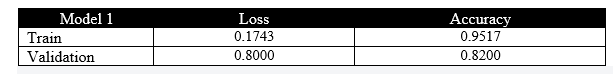


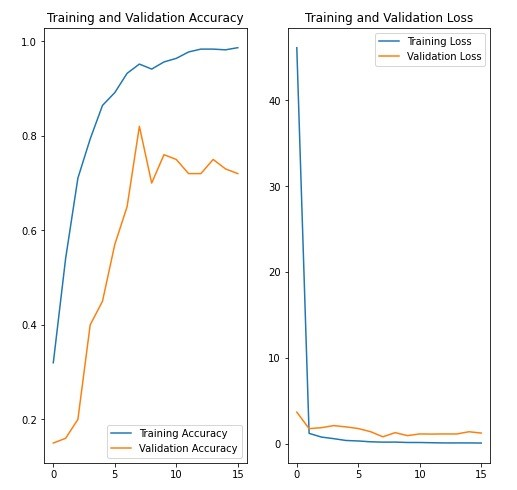


## <font color = "blue">  Model - 2

### Parameters:
- Batch_Size = 20, 
- Image_Size = (160,160), 
- Epochs = 16

### Intuition:
- The batch size is increased to 20 and the image size is reconfigured to (160,160). The architecture used eight convolutions with kernel size of (3, 3, 3). This is then followed by two dense neural networks. The first convolution network has 16 filters, the second and third network has 32 filters, the fourth, fifth and sixth convolution layers have 64 filters and the last two convolution layers have 128 filters. The activation functions used in the convolution nets is “relu”. This is then followed by two dense networks of 64 neurons. The dropouts are being introduced after each dense layer. The final dense layer has 5 output neurons with softmax.

In [13]:
# model = Sequential()
# filtersize=(3, 3,3)
# model.add(Conv3D(16, filtersize, padding='same',
#                  input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())

# model.add(Conv3D(32, filtersize, padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(Conv3D(32, filtersize, padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())        
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, filtersize, padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(Conv3D(64, filtersize, padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())

# model.add(Conv3D(64, filtersize, padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, filtersize, padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(Conv3D(128, filtersize, padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())        
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))       

# model.add(Flatten())
# model.add(Dense(64,activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(64,activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
# model.add(Dense(5,activation='softmax'))

The train and validation performance are presented below:

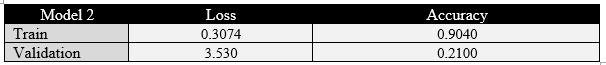

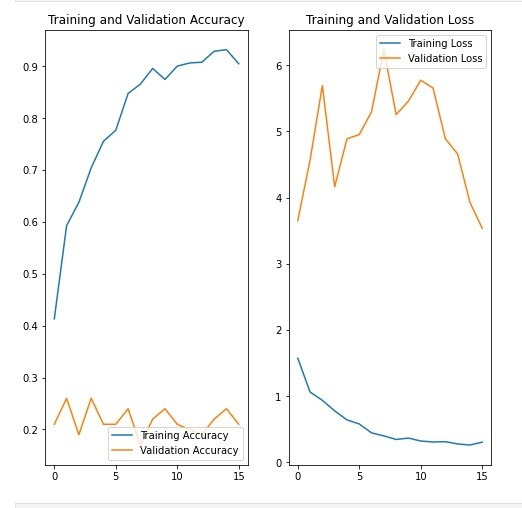

The model performance is much poor then the base model itself and hence we decided to reduce the number of layers.

## <font color = "blue">  Model - 3

### Parameters:
- Batch_Size = 12, 
- Image_Size = (160,160), 
- Epochs = 16

### Intuition:

As increasing the number of convulations layers did not result into increase in validation accuracy and hence in this trial the number of layers have been reduced keeping the batch size and the image size same. The kernel size and the activation functions have also been kept same. The Batch Normalization has been applied after each convulation layer. The max pooling layers of pool size (2, 2, 2) have been used after the second, third and fourth convulation layers. The number of epochs is maintained at 16. The model is composed of four convulation layers. The first and second layer has 32 filters, the next has 64 filters, the last layer has 128 filters. The dense networks and the dropouts have been kept the same as in the previous model.

In [14]:
# model = Sequential()
# model.add(Conv3D(32, (3, 3, 3), padding='same',
#                  input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())

# model.add(Conv3D(32, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
# model.add(Flatten())
# model.add(Dense(64,activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(64,activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
# model.add(Dense(5,activation='softmax'))

The train and validation performance is:

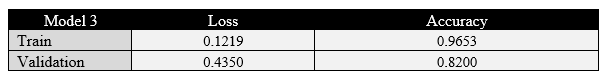

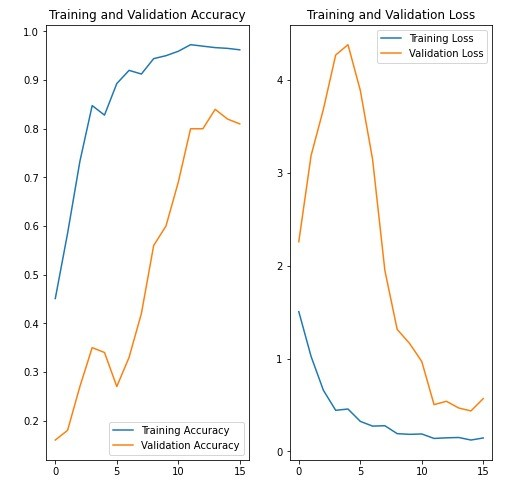

This model has shown handsome performance with the validation data. From next model, we shift our focus towards the second methodology which is CNN+RNN.

## <font color = "blue">  Model - 4

### Parameters:
- Batch_Size = 12, 
- Image_Size = (160,160), 
- Epochs = 16

### Intuition:
- In this model, the architecture uses the Long Short Term Memory Cells. The model uses four two-dimensional convulation layers having 16 filters and kernel size of (2,2). The number of epochs have been kept at 16 like previous models only. The activation functions employed here is rectified linear unit. Batch Normalization has been used after each convulation layer. The max pooling layers have been used after the first two layers and a dropout layer of 0.2 dropout. The next max pooling and dropouts have been employed after the third and fourth layer. 
All these layers are time distributed networks in line with the RNN tenets. After the convulation layers, the LSTM cell with 256 neurons cells have been employed with a dropout of 0.5. This is followed by a dense neuron network of 64 neurons and dropout of 0.25. The last layer is the output with 5 output neurons and softmax activation


In [15]:
# model = Sequential()
# model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'),
#                  input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(TimeDistributed(Conv2D(16, (2, 2))))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
# model.add(Dropout(0.2))

# model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same')))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same')))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
# model.add(Dropout(0.2))

# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(256, return_sequences=False, dropout=0.5))
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))
# model.add(Dense(5))
# model.add(Activation('softmax'))

The model performance is as below:

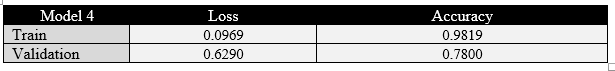

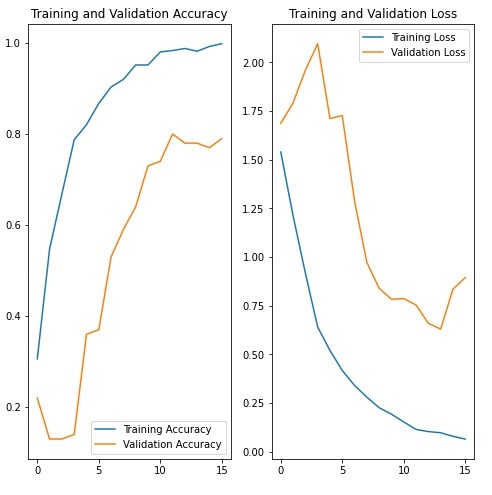

The CNN+RNN architecture is performing well. Let's explore it a bit further.

## <font color = "blue">  Model - 5

### Parameters:
- Batch_Size = 12, 
- Image_Size = (160,160), 
- Epochs = 16

### Intuition:
- In this model we use the concept of Gated Recurrent Units. The key difference between GRU and LSTM is that GRU's bag has two gates that are reset and update while LSTM has three gates that are input, output, forget. GRU is less complex than LSTM because it has less number of gates. If the dataset is small then GRU is preferred otherwise LSTM for the larger dataset. Thus the GRU model is being used in this study to see if it is more efficient for this particular task. In this model, the batch size has been kept at 12 , image sizes (160.160) and number of epochs at 16. The model is built up of 4 convulational units. The first layer has 16 filters, followed by 32 filters. This is being followed up by 64 filters and last CNN layer has 128 filters. The kernel size is kept at (2,2) for first layer and (3,3) for remaining layers. The batch normalization and max pooling has been performed after each CNN layer.This is then folllowed up by the GRU layer of 256 neurons. This is then succedded by a dropout layer. The remaining network is composed of densely connected neural nets finally giving an output of 5 classes with softmax activation.

In [16]:
# model = Sequential()

# model.add(TimeDistributed(Conv2D(16, (2, 2) , padding='same', activation='relu'),
#                                   input_shape=input_shape))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
# model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
# model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
# model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))        

# model.add(TimeDistributed(Flatten()))
# model.add(GRU(256))
# model.add(Dropout(0.25))        
# model.add(Dense(128,activation='relu'))
# model.add(Dropout(0.25))        
# model.add(Dense(5, activation='softmax'))

The model performance is as below:

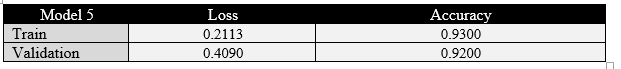

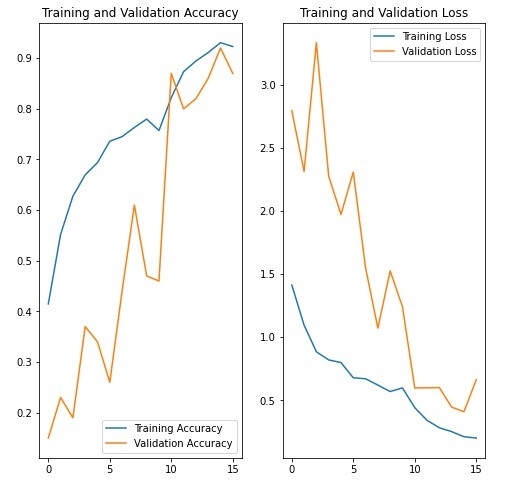

So far we have achieved good accuracy using CNN+RNN architectures. This encouraged us to try using the Transfer learning route. We go on to use RESNET & MOBILENET to design our architecture.

## <font color = "blue">  Model - 6

### Parameters:
- Batch_Size = 12, 
- Image_Size = (160,160), 
- Epochs = 16
- Transfer Learning Model :  RESNET

### Intuition:
- The study now focusses on using the Resnet architecture to convolve on the images which is then coupled with the Gated Recurrent Units to make predictions on the validation set. Here also, the batch sizes are kept at 12m, image sizes at (160,160) and epoch is set to 12. The model uses the weights similar to that of the resnet model. After the CNN layer a Batch Normalization layer and max pooling is applied. This is then followed by GRU units of 128 neurons. This is then followed by dense network of 64 neurons and the final output neuron has 5 output neurons with softmax function.

In [17]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=transfer_learning_shape)
for layer in resnet.layers[:-1]:
    layer.trainable=False

2023-02-13 13:25:29.056644: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-13 13:25:29.056706: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


In [18]:
# model = Sequential()
# model.add(TimeDistributed(resnet,input_shape=input_shape))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
# model.add(TimeDistributed(Flatten()))
# model.add(GRU(128, return_sequences=False))
# #model.add(Dropout(0.2))
# model.add(Dense(64))
# #model.add(Dropout(0.2))
# model.add(Activation('relu'))
# model.add(Dense(5))
# model.add(Activation('softmax'))

The performance is:

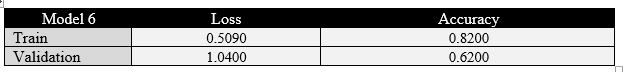

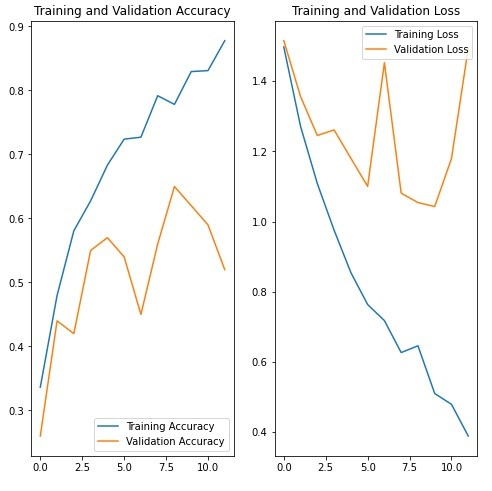

## <font color = "blue">  Model - 7

### Parameters:
- Batch_Size = 12, 
- Image_Size = (160,160), 
- Epochs = 16
- Transfer Learning Model :  MOBILENET

### Intuition:

- The transfer learning model Mobilenet is now being used to train the model. MobileNet is a streamlined architecture that uses depthwise separable convolutions to construct lightweight deep convolutional neural networks and provides an efficient model for embedded vision applications. Now this advantage of mobilenet is being harnessed to work alongwith the Gated Recurrent Units to test on the validation data. Here also, the batch sizes are kept at 12m, image sizes at (160,160) and epoch is set to 12. The model uses the weights similar to that of the resnet model. After the CNN layer a Batch Normalization layer and max pooling is applied. This is then followed by GRU units of 128 neurons. This is then followed by dense network of 64 neurons and the final output neuron has 5 output neurons with softmax function.

In [19]:
mobilenet = mobilenet.MobileNet(include_top=False,weights='imagenet',input_shape=transfer_learning_shape)
for layer in mobilenet.layers[:-1]:
    layer.trainable=False

In [20]:
model = Sequential()
model.add(TimeDistributed(mobilenet,input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(5))
model.add(Activation('softmax'))

The next step is to `compile` the model.

In [21]:
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])#labels are one hot encoded
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 5, 5, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 5, 5, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 2, 2, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 4096)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)               1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [22]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

## Visulizing Sample Data

Source path =  /home/datasets/Project_data/val ; batch size = 12


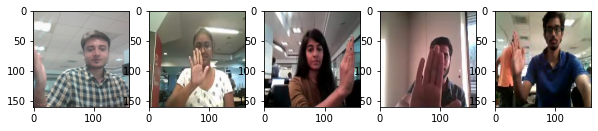

In [23]:
batch_data, batch_labels=next(generator(val_path, val_doc, batch_size))
fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(10,10))
axes[0].imshow(batch_data[0,0,:,:,:])   
axes[1].imshow(batch_data[1,3,:,:,:])
axes[2].imshow(batch_data[2,5,:,:,:])   
axes[3].imshow(batch_data[3,10,:,:,:])
axes[4].imshow(batch_data[4,14,:,:,:])   

Source path =  /home/datasets/Project_data/val ; batch size = 12


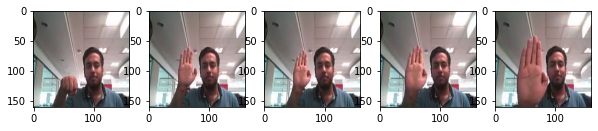

In [24]:
batch_data, batch_labels=next(generator(val_path, val_doc, batch_size))
fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(10,10))
axes[0].imshow(batch_data[0,0,:,:,:])   
axes[1].imshow(batch_data[0,3,:,:,:])
axes[2].imshow(batch_data[0,5,:,:,:])   
axes[3].imshow(batch_data[0,10,:,:,:])
axes[4].imshow(batch_data[0,14,:,:,:]) 

## Defining Callbacks for saving the model and adjusting the learning rate

In [25]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [26]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## The Model Training

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [27]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 12
Epoch 1/12


2023-02-13 13:25:40.746649: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


56/56 [==============================] - ETA: 0s - loss: 1.0261 - categorical_accuracy: 0.5807Source path =  /home/datasets/Project_data/val ; batch size = 12

Epoch 00001: val_loss improved from inf to 0.60227, saving model to model_init_2023-02-1313_25_28.249918/model-00001-1.02608-0.58069-0.60227-0.83000.h5
56/56 [==============================] - 92s 2s/step - loss: 1.0261 - categorical_accuracy: 0.5807 - val_loss: 0.6023 - val_categorical_accuracy: 0.8300 - lr: 0.0010
Epoch 2/12
56/56 [==============================] - ETA: 0s - loss: 0.3489 - categorical_accuracy: 0.8899
Epoch 00002: val_loss improved from 0.60227 to 0.31077, saving model to model_init_2023-02-1313_25_28.249918/model-00002-0.34891-0.88989-0.31077-0.93000.h5
56/56 [==============================] - 89s 2s/step - loss: 0.3489 - categorical_accuracy: 0.8899 - val_loss: 0.3108 - val_categorical_accuracy: 0.9300 - lr: 0.0010
Epoch 3/12
56/56 [==============================] - ETA: 0s - loss: 0.1608 - categorical_accur

Hence the performance is as follows:


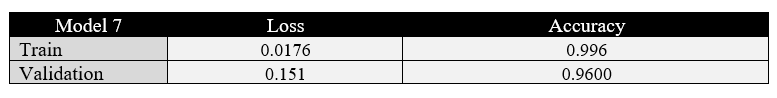

## Visualizing Train and Validation Performance

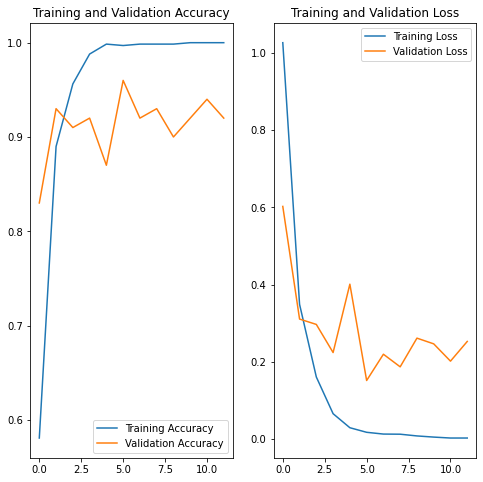

In [28]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Visualizing the Prediction Results

Source path =  /home/datasets/Project_data/val ; batch size = 12
(12, 15, 160, 160, 3)
(15, 160, 160, 3)
(12, 5)
(12,)
actual class: left_swipe
predictive class: left_swipe


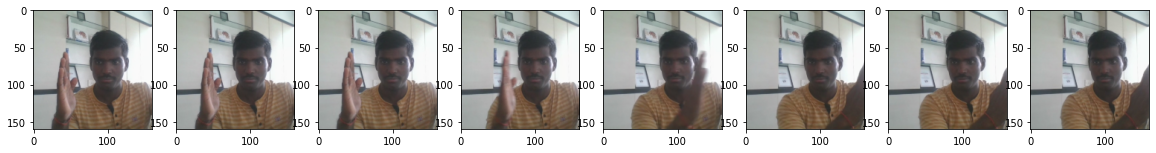

In [29]:
#show the prediction on test data(one sample)
check_index=0
batch_data, batch_labels=next(generator(val_path, val_doc, batch_size))
fig, axes = plt.subplots(nrows=1, ncols=8,figsize=(20,10))
axes[0].imshow(batch_data[0,0,:,:,:])   
axes[1].imshow(batch_data[0,2,:,:,:])
axes[2].imshow(batch_data[0,4,:,:,:])   
axes[3].imshow(batch_data[0,6,:,:,:])
axes[4].imshow(batch_data[0,8,:,:,:])
axes[5].imshow(batch_data[0,10,:,:,:])   
axes[6].imshow(batch_data[0,12,:,:,:])
axes[7].imshow(batch_data[0,14,:,:,:]) 
class_names=["left_swipe","right_swipe","stop","Thumbs_down","Thumbs_Up"]
#img = np.expand_dims(test_image,axis=0)
#img = np.expand_dims(batch_data,axis=0)
prediction_class_prob = model.predict(batch_data)
prediction_class_index = np.argmax(prediction_class_prob,axis=1)
actual_class_index = np.argmax(batch_labels,axis=1)
print(batch_data.shape)
print(batch_data[:,:,:,:,:][0].shape)
print(batch_labels.shape)
print(prediction_class_index.shape)
# prediction_class_prob = model.predict(test_image)
# prediction_class_index = np.argmax(prediction_class_prob,axis=1)
pred_class_name = class_names[prediction_class_index[check_index]]
actual_class_name = class_names[actual_class_index[check_index]]
print("actual class: "+ actual_class_name +'\n'+ "predictive class: "+pred_class_name )

## Conclusion
In this experimental study, the intial investigations began with creating a 3D CNN model to check for its feasibility on the given dataset. This was followed by introduction of more layers of CNN. In Model-2, eight CNN layers were introduced but this did not effect the performance significantly. Thus the focus was shifted to have the data tested on less deep models. In model-3, the CNN network had fewer layers and the performance was significantly better. This three experiments were done by using the Convolution 3D methodology. Amongst the models, Model 3 performed the best. 

Then the focus shifted to the CNN+RNN architectural model. Model-4 saw CNN layers coupled with LSTM model. The model did perform good, but the search was on for better performing architectures and hence, GRU was coupled with CNN and the results did improve in Model-5 from the previous model. The final approach was to use the transfer learning with GRU and hence, RESNET (model-6) & MOBILENET(model-7) were used to train and validate the dataset.The Mobilenet+GRU model was found to be the best performing architecture and this is considered for final submission. This model gave a training accuracy of 99.6% and 96% accuracy for validation set. Hence, the MOBILENET + GRU architecture developed in the seven model is found to be best fit model for gesture recognition application 


| Model Number | Batch Size | Image Size | Epochs | Training Loss | Training Accuracy | Validation Loss | Validation Accuracy
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 1 | 8 | (180,180) | 16 | 0.174 | 0.951 | 0.8 | 0.820 |
| 2 | 20 | (160,160) | 16 | 0.30746 | 0.904 | 3.53 | 0.210 |
| 3 | 12 | (160,160) | 16 | 0.121 | 0.965 | 0.435 | 0.820 |
| 4 | 12 | (160,160) | 16 | 0.096 | 0.98 | 0.629 | 0.78 |
| 5 | 12 | (160,160) | 16 | 0.211 | 0.93 | 0.409 | 0.920 |
| 6 | 12 | (160,160) | 12 | 0.509 | 0.82 | 1.04 | 0.620 |
| 7 | 12 | (160,160) | 12 | 0.0176 | 0.996 | 0.151 | 0.96 |

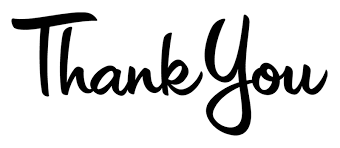